

# Working with ECoG data

MNE supports working with more than just MEG and EEG data. Here we show some of the
functions that can be used to facilitate working with electrocorticography (ECoG) data.

This example shows how to use:

- ECoG data ([available here](https://openneuro.org/datasets/ds003029)_) from
  an epilepsy patient during a seizure
- channel locations in FreeSurfer's ``fsaverage`` MRI space
- projection onto a pial surface

For a complementary example that involves sEEG data, channel locations in MNI
space, or projection into a volume, see `tut-working-with-seeg`.

Please note that this tutorial requires 3D plotting dependencies (see
`manual-install`) as well as ``mne-bids`` which can be installed using
``pip``.


In [20]:
# Authors: Eric Larson <larson.eric.d@gmail.com>
#          Chris Holdgraf <choldgraf@gmail.com>
#          Adam Li <adam2392@gmail.com>
#          Alex Rockhill <aprockhill@mailbox.org>
#          Liberty Hamilton <libertyhamilton@gmail.com>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps
from mne_bids import BIDSPath, read_raw_bids

import mne
from mne.viz import plot_alignment, snapshot_brain_montage

print(__doc__)

# paths to mne datasets - sample ECoG and FreeSurfer subject
bids_root = mne.datasets.epilepsy_ecog.data_path()
sample_path = mne.datasets.sample.data_path()
subjects_dir = sample_path / "subjects"

Automatically created module for IPython interactive environment


## Load in data and perform basic preprocessing

Let's load some ECoG electrode data with `MNE-BIDS`_.

<div class="alert alert-info"><h4>Note</h4><p>Downsampling is just to save execution time in this example, you should
    not need to do this in general!</p></div>



In [22]:
# first define the bids path
bids_path = BIDSPath(
    root=bids_root,
    subject="pt1",
    session="presurgery",
    task="ictal",
    datatype="ieeg",
    extension=".vhdr",
)

# Then we'll use it to load in the sample dataset. This function changes the
# units of some channels, so we suppress a related warning here by using
# verbose='error'.
raw = read_raw_bids(bids_path=bids_path, verbose="error")

# Pick only the ECoG channels, removing the EKG channels
raw.pick(picks="ecog")

# Load the data
raw.load_data()

# Then we remove line frequency interference
raw.notch_filter([60], trans_bandwidth=3)

# drop bad channels
raw.drop_channels(raw.info["bads"])

# the coordinate frame of the montage
montage = raw.get_montage()
print(montage.get_positions()["coord_frame"])

# add fiducials to montage
montage.add_mni_fiducials(subjects_dir)

# now with fiducials assigned, the montage will be properly converted
# to "head" which is what MNE requires internally (this is the coordinate
# system with the origin between LPA and RPA whereas MNI has the origin
# at the posterior commissure)
raw.set_montage(montage)

# Make a 25 second epoch that spans before and after the seizure onset
epoch_length = 25  # seconds
epochs = mne.Epochs(
    raw,
    event_id="onset",
    tmin=13,
    tmax=13 + epoch_length,
    baseline=None,
)
# Make evoked from the one epoch and resample
evoked = epochs.average().resample(200)
del epochs

Reading 0 ... 269079  =      0.000 ...   269.079 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 58 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 58.35
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 57.60 Hz)
- Upper passband edge: 61.65 Hz
- Upper transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 62.40 Hz)
- Filter length: 2201 samples (2.201 s)

mni_tal
Used Annotations descriptions: ['AD1-4, ATT1,2', 'AST1,3', 'G16', 'PD', 'SLT1-3', 'offset', 'onset']
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


## Explore the electrodes on a template brain

Our electrodes are shown after being morphed to fsaverage brain so we'll use
this fsaverage brain to plot the locations of our electrodes. We'll use
:func:`~mne.viz.snapshot_brain_montage` to save the plot as image data
(along with xy positions of each electrode in the image), so that later
we can plot frequency band power on top of it.



In [23]:
fig = plot_alignment(
    raw.info,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=subjects_dir,
    surfaces=["pial"],
    coord_frame="head",
    sensor_colors=(1.0, 1.0, 1.0, 0.5),
)
mne.viz.set_3d_view(fig, azimuth=0, elevation=70, focalpoint="auto", distance="auto")

xy, im = snapshot_brain_montage(fig, raw.info)

Channel types::	ecog: 84


## Compute frequency features of the data

Next, we'll compute the signal power in the gamma (30-90 Hz) band,
downsampling the result to 10 Hz (to save time).



In [24]:
sfreq = 10
gamma_power_t = (
    evoked.copy().filter(30, 90).apply_hilbert(envelope=True).resample(sfreq)
)
gamma_info = gamma_power_t.info

Setting up band-pass filter from 30 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 95.00 Hz)
- Filter length: 89 samples (0.445 s)



## Plot Gamma Power on cortical sensors

We will now use evoked gamma power to plot on the cortical surface.
Therefore we extract the evoked time sample at 15s and normalize
it in a range of 0 to 1 in order to map it using a matplotlib colormap.



In [25]:
gamma_power_at_15s = gamma_power_t.to_data_frame(index="time").loc[15]
# scale values to be between 0 and 1, then map to colors
gamma_power_at_15s -= gamma_power_at_15s.min()
gamma_power_at_15s /= gamma_power_at_15s.max()
rgba = colormaps.get_cmap("viridis")
sensor_colors = np.array(gamma_power_at_15s.map(rgba).tolist(), float)
sensor_colors[:, 3] = 0.5

fig = plot_alignment(
    raw.info,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=subjects_dir,
    surfaces=["pial"],
    coord_frame="head",
    sensor_colors=sensor_colors,
)

mne.viz.set_3d_view(fig, azimuth=0, elevation=70, focalpoint="auto", distance="auto")

xy, im = snapshot_brain_montage(fig, raw.info)

Channel types::	ecog: 84


## Visualize the time-evolution of the gamma power on the brain

Say we want to visualize the evolution of the power in the gamma band,
instead of just plotting the average. We can use
`matplotlib.animation.FuncAnimation` to create an animation and apply this
to the brain figure.



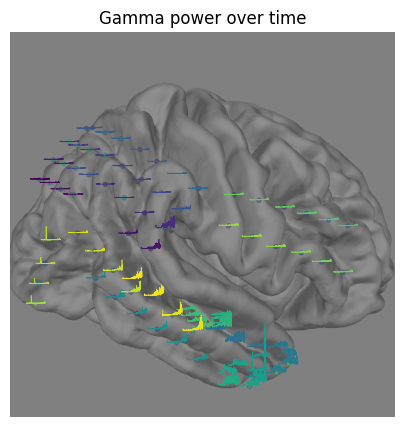

In [26]:
# convert from a dictionary to array to plot
xy_pts = np.vstack([xy[ch] for ch in raw.info["ch_names"]])

# get a colormap to color nearby points similar colors
cmap = plt.colormaps["viridis"]

# create the figure of the brain with the electrode positions
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Gamma power over time", size="large")
ax.imshow(im)
ax.set_axis_off()

# normalize gamma power for plotting
gamma_power = -100 * gamma_power_t.data / gamma_power_t.data.max()
# add the time course overlaid on the positions
x_line = np.linspace(
    -0.025 * im.shape[0], 0.025 * im.shape[0], gamma_power_t.data.shape[1]
)
for i, pos in enumerate(xy_pts):
    x, y = pos
    color = cmap(i / xy_pts.shape[0])
    ax.plot(x_line + x, gamma_power[i] + y, linewidth=0.5, color=color)

We can project gamma power from the sensor data to the nearest locations on
the pial surface and visualize that:

As shown in the plot, the epileptiform activity starts in the temporal lobe,
progressing posteriorly. The seizure becomes generalized eventually, after
this example short time section. This dataset is available using
:func:`mne.datasets.epilepsy_ecog.data_path` for you to examine.



In [ ]:
xyz_pts = np.array([dig["r"] for dig in evoked.info["dig"]])

src = mne.read_source_spaces(
    subjects_dir / "fsaverage" / "bem" / "fsaverage-ico-5-src.fif"
)
stc = mne.stc_near_sensors(
    gamma_power_t,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=subjects_dir,
    src=src,
    surface="pial",
    mode="nearest",
    distance=0.02,
)
vmin, vmid, vmax = np.percentile(gamma_power_t.data, [10, 25, 90])
clim = dict(kind="value", lims=[vmin, vmid, vmax])
brain = stc.plot(
    surface="pial",
    hemi="rh",
    colormap="inferno",
    colorbar=False,
    clim=clim,
    views=["lat", "med"],
    subjects_dir=subjects_dir,
    size=(250, 250),
    smoothing_steps="nearest",
    time_viewer=False,
)
brain.add_sensors(raw.info, trans="fsaverage")
del brain

# You can save a movie like the one on our documentation website with:
# brain.save_movie(time_dilation=1, interpolation='linear', framerate=3,
#                  time_viewer=True)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Projecting data from 84 sensors onto 20484 surface vertices: nearest mode
    Projecting sensors onto surface
Nearest-neighbor searches will be significantly faster if scikit-learn is installed.
    Minimum projected intra-sensor distance: 2.3 mm
    4932 / 20484 non-zero vertices


Channel types::	ecog: 84
Channel types::	ecog: 84


: 